# Creating a LlamaIndex RAG Pipeline with NL2SQL and Metadata Filtering!

We'll be putting together a system for querying both qualitative and quantitative data using LlamaIndex.

The acitvities will be broken down as follows:

- 🤝 Breakout Room #1
  - Task 1: Load Dependencies
  - Task 2: Set Env Variables and Set Up WandB Callback
  - Task 3: Initialize Settings
  - Task 4: Semantic RAG Pipeline with Metadata Filtering
- 🤝 Breakout Room #2
  - Task 1: Quantitative RAG Pipeline with NL2SQL Tooling
  - Task 2: Combined RAG Pipeline

Before we get started, however, a quick note on terminology.


### A note on terminology:

You'll notice that there are quite a few similarities between LangChain and LlamaIndex. LlamaIndex can largely be thought of as an extension to LangChain, in some ways - but they moved some of the language around. Let's spend a few moments disambiguating the language.

- `QueryEngine` -> `LCEL Chain`:
  -  `QueryEngine` is just LlamaIndex's way of indicating something is an LLM "chain" on top of a retrieval system
- `OpenAIAgent` vs. `Agent`:
  - The two agents have the same fundamental pattern: Decide which of a list of tools to use to answer a user's query.
  - `OpenAIAgent` (LlamaIndex's primary agent) does not need to rely on an agent excecutor due to the fact that it is leveraging OpenAI's [functional api](https://openai.com/blog/function-calling-and-other-api-updates) which allows the agent to interface "directly" with the tools instead of operating through an intermediary application process.

There is, however, a much large terminological difference when it comes to discussing data.

##### Nodes vs. Documents

As you're aware of from the previous weeks assignments, there's an idea of `documents` in NLP which refers to text objects that exist within a corpus of documents.

LlamaIndex takes this a step further and reclassifies `documents` as `nodes`. Confusingly, it refers to the `Source Document` as simply `Documents`.

The `Document` -> `node` structure is, almost exactly, equivalent to the `Source Document` -> `Document` structure found in LangChain - but the new terminology comes with some clarity about different structure-indices.

We won't be leveraging those structured indicies today, but we will be leveraging a "benefit" of the `node` structure that exists as a default in LlamaIndex, which is the ability to quickly filter nodes based on their metadata.

![image](https://i.imgur.com/B1QDjs5.png)

# 🤝 Breakout Room #1

## BOILERPLATE

This is only relevant when running the code in a Jupyter Notebook.

In [2]:
import nest_asyncio

nest_asyncio.apply()

import logging
import sys

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

## Task 1: Load Dependencies

Let's grab our core `llama-index` library, as well as OpenAI's Python SDK.

We'll be leveraging OpenAI's suite of APIs to power our RAG pipelines today.

> NOTE: You can safely ignore any pip errors that occur during the running of these cells.

In [3]:
!pip install -qU llama-index openai


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


We'll be using [Weights and Biases](https://docs.wandb.ai/guides/prompts) (WandB) again for today's notebook!

In [4]:
!pip install -qU wandb llama-index-callbacks-wandb


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


We'll be collecting our semantic data from Wikipedia - and so will need the [Wikipedia Reader](https://github.com/run-llama/llama_index/tree/main/llama-index-integrations/readers/llama-index-readers-wikipedia)!

In [5]:
!pip install -qU wikipedia llama-index-readers-wikipedia


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


Our vector database today will be powered by [ChromaDB](https://github.com/chroma-core/chroma) and so we'll need that package as well!

In [6]:
!pip install -qU chromadb llama-index-vector-stores-chroma


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


Finally, we'll need to grab a few dependencies related to our quantitative data!

In [7]:
!pip install -q -U sqlalchemy pandas


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


We'll grab some additional miscellaneous dependencies here.

In [8]:
!pip install -U -q tiktoken==0.4.0 sentence-transformers==2.2.2 pydantic==1.10.11

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-openai 0.0.8 requires tiktoken<1,>=0.5.2, but you have tiktoken 0.4.0 which is incompatible.

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [9]:
!pip install -U tiktoken==0.5.2  # Upgrade tiktoken to at least 0.5.2
!pip install -U spacy==3.7.0  # Install a compatible version of spacy
!pip install -U sentence-transformers==2.2.2  # Re-confirm the desired version
!pip install -U pydantic==1.10.11  # Re-confirm the desired version

  Using cached tiktoken-0.5.2-cp311-cp311-macosx_11_0_arm64.whl (953 kB)
  Attempting uninstall: tiktoken
    Found existing installation: tiktoken 0.4.0
    Uninstalling tiktoken-0.4.0:
      Successfully uninstalled tiktoken-0.4.0

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


## Task 2: Set Env Variables and Set Up WandB Callback

Let's set our API keys for both OpenAI and WandB!

In [10]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key: ")

In [11]:
os.environ["WANDB_API_KEY"] = getpass.getpass("WandB API Key: ")

We'll also need to set a callback handler for WandB to ensure smooth operation of our traces!

In [12]:
import llama_index
from llama_index.core import set_global_handler

set_global_handler("wandb", run_args={"project": "aie1-llama-index-demo"})
wandb_callback = llama_index.core.global_handler

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Streaming LlamaIndex events to W&B at https://wandb.ai/colinrdavismba/aie1-llama-index-demo/runs/e16rhcux
wandb: `WandbCallbackHandler` is currently in beta.
wandb: Please report any issues to https://github.com/wandb/wandb/issues with the tag `llamaindex`.


### Task 3: Settings

LlamaIndex lets us set global settings which we can use to influence the default behaviour of our components.

Let's set our LLM and our Embedding Model!

In [13]:
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core import Settings

Settings.llm = OpenAI(model="gpt-3.5-turbo")
Settings.embed_model = OpenAIEmbedding(model="text-embedding-3-small")

## Task 4: Semantic RAG Pipeline with Metadata Filtering

Now we can get to work creating our semantic `QueryEngine`!

We'll start, as we normally do, by grabbing some data.

> NOTE: Remember that a query engine is just a different word for a chain!

### Data Collection

We're just going to be pulling information straight from Wikipedia using the built in `WikipediaReader`.

> NOTE: Setting `auto_suggest=False` ensures we run into fewer auto-correct based errors.

In [14]:
from llama_index.readers.wikipedia import WikipediaReader

movie_list = ["Dune (2021 film)", "Dune: Part Two"]

wiki_docs = WikipediaReader().load_data(pages=movie_list, auto_suggest=False)

### Initializing our VectorStoreIndex with ChromaDB

ChromaDB is a locally hostable and open-source vector database solution.

It offers powerful features like metadata filtering out of the box, and will suit our needs well today!

We'll start by creating our local `EphemeralClient()` (in-memory and not meant for production use-cases) and our collection.

Then we'll create our `VectorStore` and `StorageContext` which will allow us to create an empty `VectorStoreIndex` which we will be able to add nodes to later!

In [15]:
from llama_index.vector_stores.chroma import ChromaVectorStore
import chromadb

chroma_client = chromadb.EphemeralClient()
chroma_collection = chroma_client.create_collection("dune-v0")

INFO:chromadb.telemetry.product.posthog:Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


In [16]:
from llama_index.core import VectorStoreIndex
from llama_index.core import StorageContext

vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
storage_context = StorageContext.from_defaults(vector_store=vector_store)
index = VectorStoreIndex.from_documents([], storage_context=storage_context)

wandb: Logged trace tree to W&B.


### Node Construction

Now we will loop through our documents and metadata and construct nodes.

We'll make sure to explicitly associate our nodes with their respective movie so we can filter by the movie title in the upcoming cells.

> NOTE: You can safely ignore any WARNINGs in the following cell.

In [17]:
from llama_index.core import SimpleDirectoryReader
from llama_index.core.ingestion import IngestionPipeline
from llama_index.core.node_parser import TokenTextSplitter
from llama_index.core.extractors import TitleExtractor

pipeline = IngestionPipeline(transformations=[TokenTextSplitter()])

for movie, wiki_doc in zip(movie_list, wiki_docs):
    nodes = pipeline.run(documents=wiki_docs)
    for node in nodes:
        node.metadata = {"title" : movie}
    index.insert_nodes(nodes)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
Add of existing embedding ID: d29a137b-a07a-427a-aae0-8a5dfb1c238f
Add of existing embedding ID: b87a3c17-3182-41fa-acb0-26ae7e8de6e0
Add of existing embedding ID: e32f7aa7-2cb1-4fde-9666-ee82688d68c8
Add of existing embedding ID: dec7244c-50b7-4952-a3c1-555edbf29cb7
Add of existing embedding ID: fef58eae-8f7e-47cd-9022-51ef5889bebd
Add of existing embedding ID: a3fe56ca-23b9-4258-821e-b4693168c48e
Add of existing embedding ID: 3d8da418-d4c3-44b1-9639-ffbc92652d51
Add of existing embedding ID: 4262039a-ce5a-415c-a7de-9c843aa362c8
Add of existing embedding ID: dd668f99-3ac4-4b3d-9373-e2a2e3cbec62
Add of existing embedding ID: 8c239ee0-935e-4839-9655-b77b8907b401
Add of exist

####❓ Question #1:

What `metadata` fields will the nodes in our index have?

Please write the code to find this information.

In [18]:
### YOUR CODE HERE
# ## super simple
print(nodes[0].metadata.keys())

dict_keys(['title'])


In [19]:
### YOUR CODE HERE
## checking first node only
first_node = nodes[0] 

# make a little more friendly to print
metadata_fields = first_node.metadata.keys()
print("Metadata fields in the first node:", list(metadata_fields))



Metadata fields in the first node: ['title']


In [20]:
#I think the only metadata it should have is title but let's check all nodes to confirm
all_metadata_fields = set()
for node in nodes:
    all_metadata_fields.update(node.metadata.keys())

print("All unique metadata fields across nodes:", list(all_metadata_fields))

All unique metadata fields across nodes: ['title']


### Persisting and Loading Stored Index with Weights and Biases

Now we can utilize a powerful feature of Weights and Biases - index and artifact versioning!

We can persist our index to WandB to be used and loaded later!

In [21]:
wandb_callback.persist_index(index, index_name="dune-index-chromadb")

wandb: Adding directory to artifact (/Users/colin.davis/Documents/aimrepo_new/homework_2_1/wandb/run-20240311_190210-e16rhcux/files/storage)... Done. 0.0s


Now we can load our index from WandB, which is a truly powerful tool!

In [22]:
from llama_index.core import load_index_from_storage

storage_context = wandb_callback.load_storage_context(
    artifact_url="colinrdavismba/aie1-llama-index-demo/dune-index-chromadb:v0"
)

wandb:   4 of 4 files downloaded.  


####❓ Question #2:

Provide a screenshot of your index version history as shown in WandB.

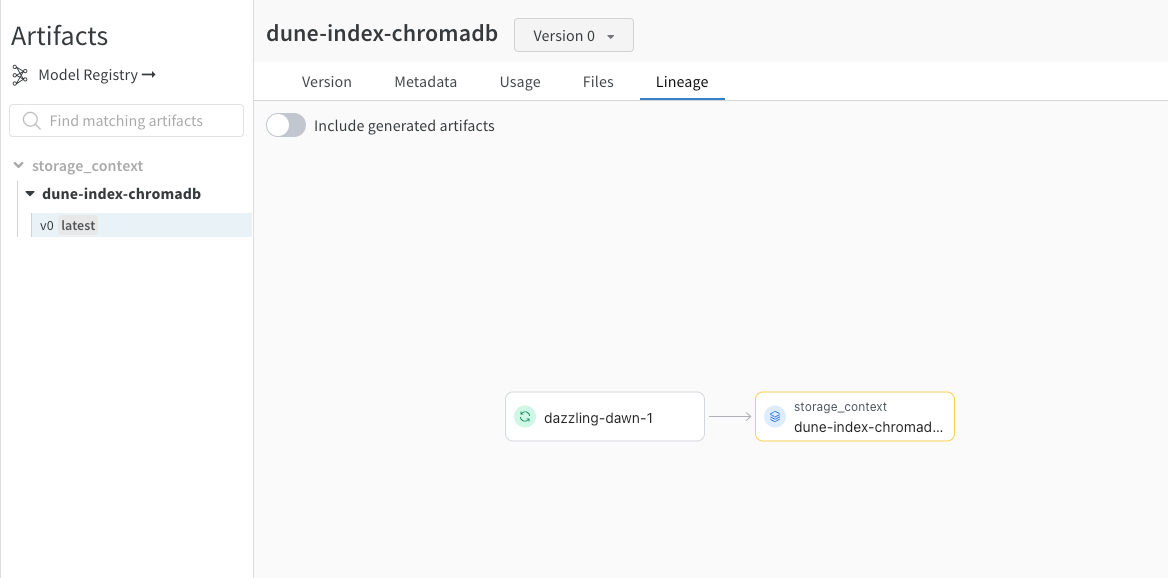

### Auto Retriever Functional Tool

This tool will leverage OpenAI's functional endpoint to select the correct metadata filter and query the filtered index - only looking at nodes with the desired metadata.

A simplified diagram: ![image](https://i.imgur.com/AICDPav.png)

First, we need to create our `VectoreStoreInfo` object which will hold all the relevant metadata we need for each component (in this case title metadata).

Notice that you need to include it in a text list.

In [23]:
from llama_index.core.tools import FunctionTool
from llama_index.core.vector_stores.types import (
    VectorStoreInfo,
    MetadataInfo,
    ExactMatchFilter,
    MetadataFilters,
)
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.query_engine import RetrieverQueryEngine

from typing import List, Tuple, Any
from pydantic import BaseModel, Field

top_k = 3

vector_store_info = VectorStoreInfo(
    content_info="semantic information about movies",
    metadata_info=[MetadataInfo(
        name="title",
        type="str",
        description="title of the movie, one of ['Dune (2021 film)', 'Dune: Part 2']",
    )]
)

Now we'll create our base PyDantic object that we can use to ensure compatability with our application layer. This verifies that the response from the OpenAI endpoint conforms to this schema.

In [24]:
class AutoRetrieveModel(BaseModel):
    query: str = Field(..., description="natural language query string")
    filter_key_list: List[str] = Field(
        ..., description="List of metadata filter field names"
    )
    filter_value_list: List[str] = Field(
        ...,
        description=(
            "List of metadata filter field values (corresponding to names specified in filter_key_list)"
        )
    )

Now we can build our function that we will use to query the functional endpoint.

In [25]:
def auto_retrieve_fn(
    query: str, filter_key_list: List[str], filter_value_list: List[str]
):
    """Auto retrieval function.

    Performs auto-retrieval from a vector database, and then applies a set of filters.

    """
    query = query or "Query"

    exact_match_filters = [
        ExactMatchFilter(key=k, value=v)
        for k, v in zip(filter_key_list, filter_value_list)
    ]
    retriever = VectorIndexRetriever(
        index, filters=MetadataFilters(filters=exact_match_filters), top_k=top_k
    )
    query_engine = RetrieverQueryEngine.from_args(retriever)

    response = query_engine.query(query)
    return str(response)

Now we need to wrap our system in a tool in order to integrate it into the larger application.

Source Code Here:
- [`FunctionTool`](https://github.com/jerryjliu/llama_index/blob/d24767b0812ac56104497d8f59095eccbe9f2b08/llama_index/tools/function_tool.py#L21)

In [26]:
description = f"""\
Use this tool to look up semantic information about films.
The vector database schema is given below:
{vector_store_info.json()}
"""

auto_retrieve_tool = FunctionTool.from_defaults(
    fn=auto_retrieve_fn,
    name="semantic-film-info",
    description=description,
    fn_schema=AutoRetrieveModel
)

####❓ Question #3:

Is the text in the description of our `FunctionTool` important or not? Please explain your answer.

In [27]:
## Answer:
"""
Yes it is very much important. The agentic workflow we are building, especially as we increase 
complexity, will depend on the description of a given tool to help the LLM reason on which 
sub task (or tool) to execute. In this case, we defined the function as:

Use this tool to look up semantic information about films.
The vector database schema is given below:
{vector_store_info.json()}. 

The LLM needs this description to comprehend, categorize, and effectively utilize 
tools within complex workflows like we are building. This will help an LLM to know 
when to utilize this tool or to not.

"""

'\nYes it is very much important. The agentic workflow we are building, especially as we increase \ncomplexity, will depend on the descrition of a given tool to help the LLM reason on which \nsub task (or tool) to execute. In this case, we defined the function as:\n\nUse this tool to look up semantic information about films.\nThe vector database schema is given below:\n{vector_store_info.json()}. \n\nThe LLM needs this description to comprehend, categorize, and effectively utilize \ntools within complex workflows like we are building. This will help an LLM to know \nwhen to utilize this tool or to not.\n\n'

All that's left to do is attach the tool to an OpenAIAgent and let it rip!

Source Code Here:
- [`OpenAIAgent`](https://github.com/jerryjliu/llama_index/blob/d24767b0812ac56104497d8f59095eccbe9f2b08/llama_index/agent/openai_agent.py#L361)

In [28]:
from llama_index.agent.openai import OpenAIAgent

agent = OpenAIAgent.from_tools(
    tools=[auto_retrieve_tool],
    verbose=True,
)

In [29]:
response = agent.chat("Who starred in the 2021 film?")
print(str(response))

Added user message to memory: Who starred in the 2021 film?
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: semantic-film-info with args: {"query":"cast","filter_key_list":["title"],"filter_value_list":["Dune (2021 film)"]}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Got output: The casting process for the film "Dune" involved a variety of actors being considered and selected for different roles. Some actors, like Rebecca Ferguson and Dave Bautista, were initially hesitant but eventually accepted their roles after discussions with the directo

wandb: Logged trace tree to W&B.


The 2021 film "Dune" starred a talented cast including:

1. Timothée Chalamet
2. Rebecca Ferguson
3. Oscar Isaac
4. Josh Brolin
5. Stellan Skarsgård
6. Dave Bautista
7. Stephen McKinley Henderson
8. Zendaya
9. Chang Chen
10. Sharon Duncan-Brewster
11. Charlotte Rampling
12. Jason Momoa
13. Javier Bardem

These actors played key roles in the film.


# 🤝 Breakout Room #2

## Task 1: Quantitative RAG Pipeline with NL2SQL Tooling

We'll walk through the steps of creating a natural language to SQL system in the following section.

> NOTICE: This does not have parsing on the inputs or intermediary calls to ensure that users are using safe SQL queries. Use this with caution in a production environment without adding specific guardrails from either side of the application.

The next few steps should be largely straightforward, we'll want to:

1. Read in our `.csv` files into `pd.DataFrame` objects
2. Create an in-memory `sqlite` powered `sqlalchemy` engine
3. Cast our `pd.DataFrame` objects to the SQL engine
4. Create an `SQLDatabase` object through LlamaIndex
5. Use that to create a `QueryEngineTool` that we can interact with through the `NLSQLTableQueryEngine`!

If you get stuck, please consult the documentation.

In [30]:
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/dune1.csv

--2024-03-11 19:03:08--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/dune1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133391 (130K) [text/plain]
Saving to: ‘dune1.csv.1’

dune1.csv.1         100%[===================>] 130.26K  --.-KB/s    in 0.05s   

2024-03-11 19:03:09 (2.60 MB/s) - ‘dune1.csv.1’ saved [133391/133391]



In [31]:
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/dune2.csv

--2024-03-11 19:03:09--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/dune2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111843 (109K) [text/plain]
Saving to: ‘dune2.csv.1’

dune2.csv.1         100%[===================>] 109.22K  --.-KB/s    in 0.04s   

2024-03-11 19:03:09 (2.86 MB/s) - ‘dune2.csv.1’ saved [111843/111843]



#### Read `.csv` Into Pandas

In [32]:
import pandas as pd

dune1_df = pd.read_csv("./dune1.csv")
dune2_df = pd.read_csv("./dune2.csv")

#### Create SQLAlchemy engine with SQLite

In [33]:
from sqlalchemy import create_engine

engine = create_engine("sqlite+pysqlite:///:memory:")

#### Convert `pd.DataFrame` to SQL tables

In [34]:
dune1_df.to_sql(
    "Dune (2021 film)",
    engine
)

274

In [35]:
dune2_df.to_sql(
    "Dune: Part 2",
    engine
)

175

#### Construct a `SQLDatabase` index

Source Code Here:
- [`SQLDatabase`](https://github.com/jerryjliu/llama_index/blob/d24767b0812ac56104497d8f59095eccbe9f2b08/llama_index/langchain_helpers/sql_wrapper.py#L9)

In [36]:
from llama_index.core import SQLDatabase

sql_database = SQLDatabase(
    engine=engine,
    include_tables=["Dune (2021 film)", "Dune: Part 2"]
)

#### Create the NLSQLTableQueryEngine interface for all added SQL tables

Source Code Here:
- [`NLSQLTableQueryEngine`](https://github.com/jerryjliu/llama_index/blob/d24767b0812ac56104497d8f59095eccbe9f2b08/llama_index/indices/struct_store/sql_query.py#L75C1-L75C1)

In [37]:
from llama_index.core.indices.struct_store.sql_query import NLSQLTableQueryEngine

sql_query_engine = NLSQLTableQueryEngine(
    sql_database=sql_database,
    tables=["Dune (2021 film)", "Dune: Part 2"],
)

#### Wrap It All Up in a `QueryEngineTool`

You'll want to ensure you have a descriptive...description.

An example is provided here:

```
Useful for translating a natural language query into a SQL query over a table containing:
John Wick 1, containing information related to reviews of the first John Wick movie, called John Wick
John Wick 2, containing information related to reviews of the second John Wick movie, called John Wick: Chapter 2
John Wick 3, containing information related to reviews of the third John Wick movie, called John Wick: Chatper 3 - Parabellum
John Wick 4, containing information related to reviews of the fourth John Wick movie, called John Wick: Chatper 4
```

Sorce Code Here:

- [`QueryEngineTool`](https://github.com/jerryjliu/llama_index/blob/d24767b0812ac56104497d8f59095eccbe9f2b08/llama_index/tools/query_engine.py#L13)

####🏗️ Activity #1:

Please write a Natural Language Description for the tables that we are using today.

In [38]:
## need to describe both of the movies we have

## Dune (2021 film), The first Dune movie released in 2021, called Dune (2021 film)
## Dune: Part 2, contains rating reviews on the second Dune movie, called Dune: Part 2

DESCRIPTION = """
Useful for translating a natural language query into a SQL query over a table containing:
Dune (2021 film), contains rating reviews on the first Dune movie, called Dune (2021 film)
## Dune: Part 2, contains rating reviews on the second Dune movie, called Dune: Part 2
"""



In [39]:
from llama_index.core.tools.query_engine import QueryEngineTool

sql_tool = QueryEngineTool.from_defaults(
    query_engine=sql_query_engine,
    name="sql-query",
    description=DESCRIPTION,
)

In [41]:
agent = OpenAIAgent.from_tools(
    tools=[sql_tool],
    verbose=True
)

In [42]:
response = agent.chat("What is the average rating of the 2nd Dune movie?")

Added user message to memory: What is the average rating of the 2nd Dune movie?
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: sql-query with args: {"input":"SELECT AVG(rating) FROM Dune_Part_2"}
INFO:llama_index.core.indices.struct_store.sql_retriever:> Table desc str: Table 'Dune (2021 film)' has columns: index (BIGINT), Unnamed: 0 (BIGINT), Review_Date (TEXT), Author (TEXT), Rating (FLOAT), Review_Title (TEXT), Review (TEXT), Review_Url (TEXT), and foreign keys: .

Table 'Dune: Part 2' has columns: index (BIGINT), Unnamed: 0 (BIGINT), Review_Date (TEXT), Author (TEXT), Rating (FLOAT), Review_Title (TEXT), Review (TEXT), Review_Url (TEXT), and foreign keys: .
> Table desc str: Table 'Dune (2021 film)' has columns: index (BIGINT), Unnamed: 0 (BIGINT), Review_Date (TEXT), Author (TEXT), Rating (FLOAT), Review_Title (TEXT)

wandb: Logged trace tree to W&B.


In [43]:
print(str(response))

The average rating for the 2nd Dune movie, "Dune: Part 2," is approximately 8.71.


### Task 2: Combined RAG Pipeline

Now, we can simply add our tools into the `OpenAIAgent`, and off we go!

In [44]:
dune_agent = OpenAIAgent.from_tools(
    tools=[auto_retrieve_tool, sql_tool],
    verbose=True
)

In [45]:
response1 = dune_agent.chat("What is the lowest rating of the 1st film?")

Added user message to memory: What is the lowest rating of the 1st film?
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: semantic-film-info with args: {"query":"lowest rating of the 1st film","filter_key_list":["title"],"filter_value_list":["Dune (2021 film)"]}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Got output: The lowest rating of the 1st film was given by Richard Roeper from The Chicago Sun-Times, who awarded the film three stars out of four.

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HT

wandb: Logged trace tree to W&B.


In [46]:
print(str(response1))

The lowest rating of the 1st film, "Dune (2021 film)," was three stars out of four given by Richard Roeper from The Chicago Sun-Times.


In [47]:
response2 = dune_agent.chat("What planet does the 1st Dune movie take place on?")

Added user message to memory: What planet does the 1st Dune movie take place on?
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: semantic-film-info with args: {"query":"planet where the 1st Dune movie takes place","filter_key_list":["title"],"filter_value_list":["Dune (2021 film)"]}
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
Got output: Arrakis

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


wandb: Logged trace tree to W&B.


In [48]:
print(str(response2))

The 1st Dune movie, "Dune (2021 film)," takes place on the planet Arrakis.


In [49]:
response3 = dune_agent.chat("Calculate the average review of each movie - and then discuss how the average review changed over time.")

Added user message to memory: Calculate the average review of each movie - and then discuss how the average review changed over time.
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
=== Calling Function ===
Calling function: sql-query with args: {"input": "SELECT AVG(review_rating) AS average_review FROM reviews WHERE movie_title = 'Dune (2021 film)'"}
INFO:llama_index.core.indices.struct_store.sql_retriever:> Table desc str: Table 'Dune (2021 film)' has columns: index (BIGINT), Unnamed: 0 (BIGINT), Review_Date (TEXT), Author (TEXT), Rating (FLOAT), Review_Title (TEXT), Review (TEXT), Review_Url (TEXT), and foreign keys: .

Table 'Dune: Part 2' has columns: index (BIGINT), Unnamed: 0 (BIGINT), Review_Date (TEXT), Author (TEXT), Rating (FLOAT), Review_Title (TEXT), Review (TEXT), Review_Url (TEXT), and foreign keys: .
> Table desc str: Table 'Dune (2021 film)' has c

wandb: Logged trace tree to W&B.


In [50]:
print(str(response3))

The average review rating for the movie "Dune (2021 film)" is not available in the database. However, the average review rating for "Dune: Part 2" is 8.71.

For "Dune (2021 film)," the average review is 7.6/10 on Rotten Tomatoes and 74 out of 100 on Metacritic. On the other hand, for "Dune: Part 2," the average review is 8.4/10 on Rotten Tomatoes and 79 out of 100 on Metacritic.

The change in average review ratings over time shows an improvement from the first film to the second film, with "Dune: Part 2" receiving higher average ratings compared to "Dune (2021 film)." This indicates a positive trend in the reception and quality of the Dune movie series.


####❓ Question #4:

How can you verify which tool was used for which query?

In [ ]:
##Answer below - hint from class: look at response object

In [51]:
# check responses
response1

AgentChatResponse(response='The lowest rating of the 1st film, "Dune (2021 film)," was three stars out of four given by Richard Roeper from The Chicago Sun-Times.', sources=[ToolOutput(content='The lowest rating of the 1st film was given by Richard Roeper from The Chicago Sun-Times, who awarded the film three stars out of four.', tool_name='semantic-film-info', raw_input={'args': (), 'kwargs': {'query': 'lowest rating of the 1st film', 'filter_key_list': ['title'], 'filter_value_list': ['Dune (2021 film)']}}, raw_output='The lowest rating of the 1st film was given by Richard Roeper from The Chicago Sun-Times, who awarded the film three stars out of four.')], source_nodes=[])

In [52]:
response2

AgentChatResponse(response='The 1st Dune movie, "Dune (2021 film)," takes place on the planet Arrakis.', sources=[ToolOutput(content='Arrakis', tool_name='semantic-film-info', raw_input={'args': (), 'kwargs': {'query': 'planet where the 1st Dune movie takes place', 'filter_key_list': ['title'], 'filter_value_list': ['Dune (2021 film)']}}, raw_output='Arrakis')], source_nodes=[])

In [53]:
response3

AgentChatResponse(response='The average review rating for the movie "Dune (2021 film)" is not available in the database. However, the average review rating for "Dune: Part 2" is 8.71.\n\nFor "Dune (2021 film)," the average review is 7.6/10 on Rotten Tomatoes and 74 out of 100 on Metacritic. On the other hand, for "Dune: Part 2," the average review is 8.4/10 on Rotten Tomatoes and 79 out of 100 on Metacritic.\n\nThe change in average review ratings over time shows an improvement from the first film to the second film, with "Dune: Part 2" receiving higher average ratings compared to "Dune (2021 film)." This indicates a positive trend in the reception and quality of the Dune movie series.', sources=[ToolOutput(content='The average review rating for the movie "Dune (2021 film)" is not available in the database.', tool_name='sql-query', raw_input={'input': "SELECT AVG(review_rating) AS average_review FROM reviews WHERE movie_title = 'Dune (2021 film)'"}, raw_output=Response(response='The av

In [61]:
# print 1 by 1 for just response1
print(response1.sources[0].tool_name)




semantic-film-info


In [62]:
## make more efficient and print all tools used in response1
for source in response1.sources:
   print(source.tool_name)


semantic-film-info


In [63]:
## make more efficient and print all tools used in response2
for source in response2.sources:
   print(source.tool_name)

semantic-film-info


In [64]:
## make more efficient and print all tools used in response3
for source in response3.sources:
   print(source.tool_name)

sql-query
sql-query
semantic-film-info
semantic-film-info


In [ ]:
#Answer
"""
Response1 just used the SQL tool, same with response 2

Response3 was more complex and used the SQL tool twice and then the semantic film info twice

"""

In [1]:
wandb_callback.finish()

NameError: name 'wandb_callback' is not defined